In [1]:
import time
start = time.time()

In [2]:
# Data processing
from tqdm import tqdm
import numpy as np
import pandas as pd
import random

# Hic, Distance and Structure creation
from numpy import linalg as LAnumpy
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix

# Data display 
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.legend_handler import HandlerLine2D

In [3]:
NB_BINS = 202
NB_STRUCTURES_TRAINING = 800
NB_STRUCTURES_TESTING = 200
EXPONENT = 1
DIGITS_FORMAT = '{0:0=4d}'
SEED = 0

In [4]:
random.seed(SEED)
np.random.seed(SEED)

In [5]:
def random_walk_function(nb_bins):
    
    # Define parameters for the walk
    dims = 3
    step_n = nb_bins - 1
    step_set = [-1, 0, 1]
    origin = np.zeros((1,dims))
    # Simulate steps in 3D
    step_shape = (step_n,dims)
    steps = np.random.choice(a=step_set, size=step_shape)
    path = np.concatenate([origin, steps]).cumsum(0)
    start = path[:1]
    stop = path[-1:]
    
    return start, stop, path

In [6]:
def compute_hic_matrix(distance_matrix, alpha):
    
    distance_matrix = np.where(distance_matrix == 0, np.inf, distance_matrix)
    
    hic_matrix = np.zeros((len(distance_matrix), len(distance_matrix)))
    hic_matrix = np.where(distance_matrix == np.inf, hic_matrix, np.power(distance_matrix, -alpha))
    
    return hic_matrix

In [7]:
def normalize_numpy(z):
    
    norm = LAnumpy.norm(z, 2, axis=1)
    max_norm = np.max(norm, axis=0)
    if max_norm == 0:
        max_norm = 1
    
    return z / max_norm

In [8]:
def centralize_numpy(z):
    return z - np.mean(z, axis=0)

In [9]:
def centralize_and_normalize_numpy(z):
    
    # Translate
    z = centralize_numpy(z)
    
    # Scale
    z = normalize_numpy(z)
    
    return z

In [10]:
def create_sphere_coordinates(x_0=0, y_0=0, z_0=0, radius=1):
    
    theta = np.linspace(0,2*np.pi,100)
    phi = np.linspace(0,np.pi,100)
    
    x = radius*np.outer(np.cos(theta), np.sin(phi)) + x_0
    y = radius*np.outer(np.sin(theta), np.sin(phi)) + y_0
    z = radius*np.outer(np.ones(100), np.cos(phi)) + z_0

    return x, y, z

In [11]:
def create_sphere_surface(x_0=0, y_0=0, z_0=0, radius=1):
    
    x, y, z = create_sphere_coordinates(x_0, y_0, z_0, radius)
    return go.Surface(x=x, y=y, z=z, opacity=0.1)

In [12]:
start, stop, path = random_walk_function(NB_BINS)
test_structure = centralize_and_normalize_numpy(path)

In [13]:
unit_sphere_surface = create_sphere_surface()
structure_scatter = go.Scatter3d(x=test_structure[:,0], 
                                                      y=test_structure[:,1], 
                                                      z=test_structure[:,2],
    marker=dict(size=4, color=np.asarray(range(len(test_structure[:,0]))), colorscale='Viridis'),
    line=dict(color='darkblue', width=2))
layout = go.Layout(width=1000, height=1000,)
fig = go.Figure(data=[unit_sphere_surface, structure_scatter], layout=layout)


fig.show()

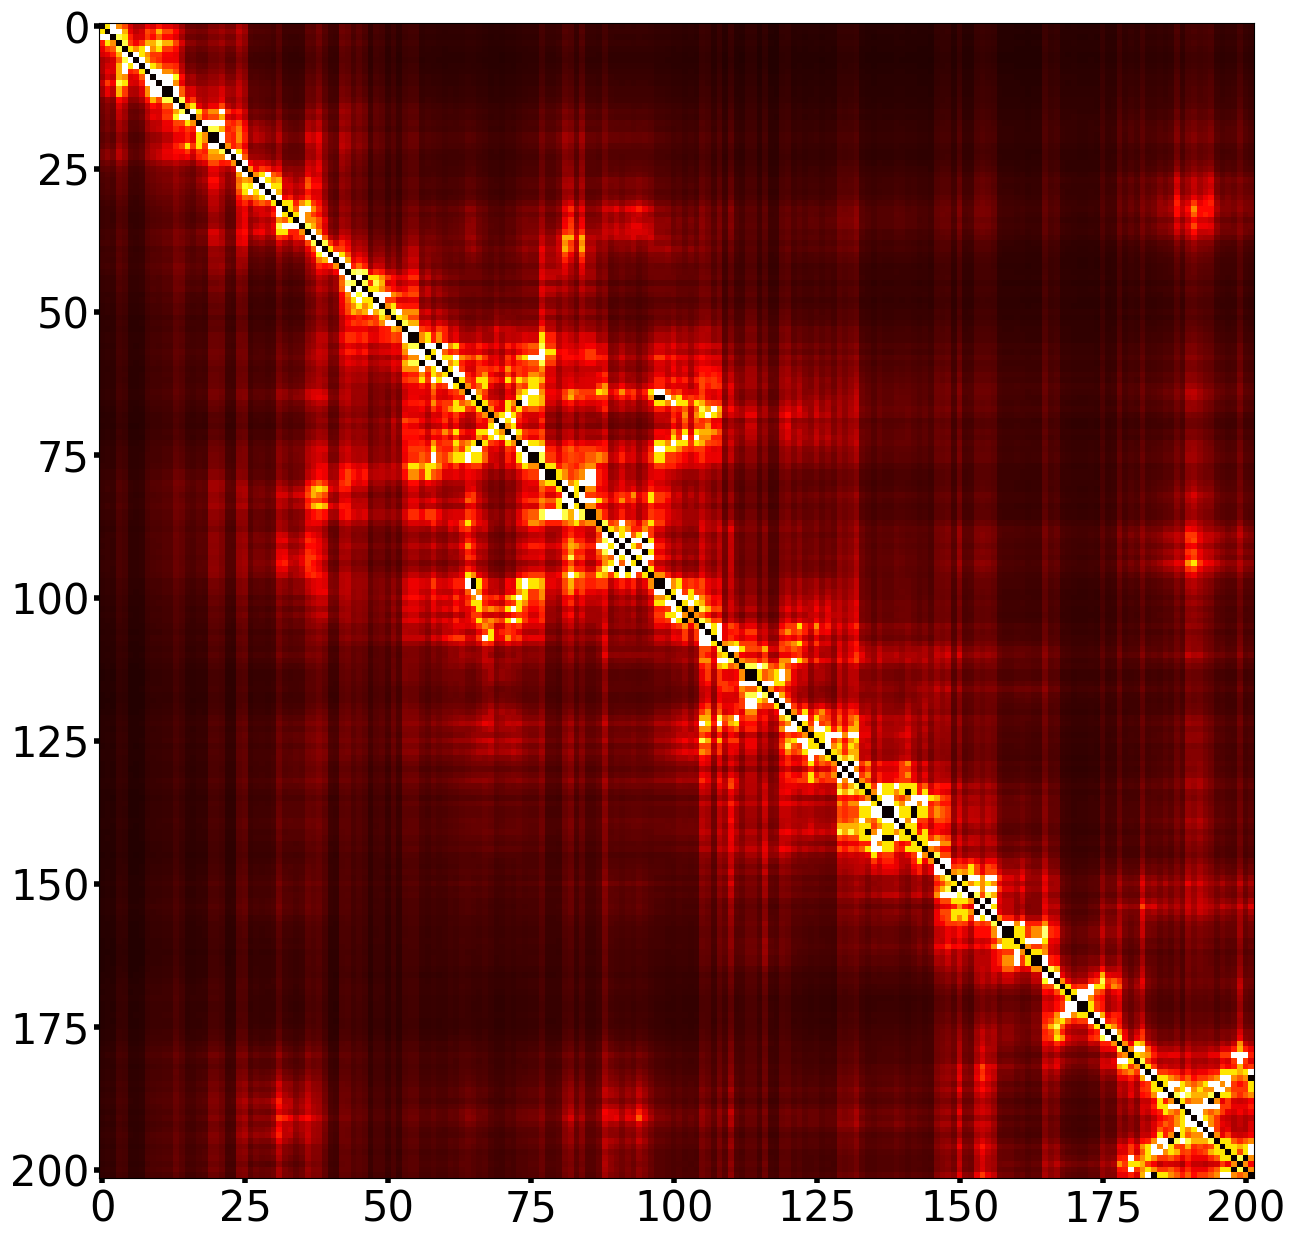

In [14]:
precomputed_distances = distance_matrix(path, path)
hic_matrix = compute_hic_matrix(precomputed_distances, EXPONENT) 
scaler = MinMaxScaler()
hic_matrix = scaler.fit_transform(hic_matrix)

fig, axs = plt.subplots(1, 1, figsize=(15,15))

axs.imshow(hic_matrix, cmap='hot', interpolation='nearest')
axs.tick_params(axis='both', which='major', labelsize=30, width=4)

plt.savefig('synthetic_random_hic_example.png')
plt.show()

In [15]:
def synthetic_random_data_generator(is_training=True):
    
    if is_training:
        nb_structures = NB_STRUCTURES_TRAINING
        file_name = 'train'
    else:
        nb_structures = NB_STRUCTURES_TESTING
        file_name = 'test'
        
    # Create Dataset (iterate with step 2 because of data augmentation)
    for i in tqdm(range(0, nb_structures, 2)):

        # Set the seeds
        random.seed(i*3 + 500)
        np.random.seed(i*1201 + 8302)

        start, stop, path = random_walk_function(NB_BINS)
        path = centralize_and_normalize_numpy(path)
        # Data augmentation
        path_inverted = np.flip(path, 0)

        # Structure matrix to file
        df = pd.DataFrame(data=path.astype(float))
        df.to_csv('data/synthetic_random/' + file_name + '/structure_matrices/synthetic_random_structure_'\
                  + DIGITS_FORMAT.format(i) + '.txt', sep=' ', header=False, index=False)
        df = pd.DataFrame(data=path_inverted.astype(float))
        df.to_csv('data/synthetic_random/' + file_name + '/structure_matrices/synthetic_random_structure_'\
                  + DIGITS_FORMAT.format(i+1) + '.txt', sep=' ', header=False, index=False)  

        # Compute distance matrix
        precomputed_distances = distance_matrix(path, path)
        # Data augmentation
        reverted_precomputed_distances = np.rot90(precomputed_distances, k=2, axes=(0,1))

        # Distance matrix to file
        df = pd.DataFrame(data=precomputed_distances.astype(float))
        df.to_csv('data/synthetic_random/' + file_name + '/distance_matrices/synthetic_random_distance_'\
                  + DIGITS_FORMAT.format(i) + '.txt', sep=' ', header=False, index=False)
        df = pd.DataFrame(data=reverted_precomputed_distances.astype(float))
        df.to_csv('data/synthetic_random/' + file_name + '/distance_matrices/synthetic_random_distance_'\
                  + DIGITS_FORMAT.format(i+1) + '.txt', sep=' ', header=False, index=False)  

        # Compute HiC matrix
        hic_matrix = compute_hic_matrix(precomputed_distances, EXPONENT) 
        # Min Max scaling
        scaler = MinMaxScaler()
        hic_matrix = scaler.fit_transform(hic_matrix)
        # Data augmentation
        reverted_hic_matrix = np.rot90(hic_matrix, k=2, axes=(0,1))

        # HiC matrix to file
        df = pd.DataFrame(data=hic_matrix.astype(float))
        df.to_csv('data/synthetic_random/' + file_name + '/hic_matrices/synthetic_random_hic_' + \
                  DIGITS_FORMAT.format(i) + '.txt', sep=' ', header=False, index=False)

        df = pd.DataFrame(data=reverted_hic_matrix.astype(float))
        df.to_csv('data/synthetic_random/' + file_name + '/hic_matrices/synthetic_random_hic_' + \
                  DIGITS_FORMAT.format(i+1) + '.txt', sep=' ', header=False, index=False)

In [16]:
synthetic_random_data_generator()

100%|██████████| 400/400 [01:43<00:00,  3.87it/s]


In [17]:
synthetic_random_data_generator(is_training=False)

100%|██████████| 100/100 [00:21<00:00,  4.60it/s]


In [18]:
end = time.time()
print(end - start)

[[1.66448634e+09 1.66448634e+09 1.66448634e+09]]
